<a href="https://colab.research.google.com/github/shintaroudlotulhanafia/TugasAkhirS1-SingleStock/blob/main/TugasAkhir_Shinta_DRLforSingleStockTrading_PPO_AMZN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Deep Reinforcement Learning for Stock Trading from Scratch: Single Stock Trading

Python Package Installation
As a first step we check if the additional packages needed are present, if not install them.

* Yahoo Finance API
* pandas
* matplotlib
* stockstats
* OpenAI gym
* stable-baselines
* tensorflow

In [1]:
import pkg_resources
import pip
installedPackages = {pkg.key for pkg in pkg_resources.working_set}
required = {'yfinance', 'pandas', 'matplotlib', 'stockstats','stable-baselines','gym','tensorflow'}
missing = required - installedPackages
if missing:
    !pip install yfinance
    !pip install pandas
    !pip install matplotlib
    !pip install stockstats
    !pip install gym
    !pip install stable-baselines[mpi]
    !pip install tensorflow==1.15.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 240 kB 4.3 MB/s 
     |████████████████████████████████| 2.5 MB 44.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build

# Import packages

In [2]:
import yfinance as yf
from stockstats import StockDataFrame as Sdf

import pandas as pd
import matplotlib.pyplot as plt

import gym
from stable_baselines import PPO2, DDPG, A2C, ACKTR, TD3
from stable_baselines import DDPG
from stable_baselines import A2C
from stable_baselines import SAC
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.common.policies import MlpPolicy

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



/usr/local/lib/python3.7/dist-packages/stable_baselines/__init__.py:33: UserWarning: stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation.
  "stable-baselines is in maintenance mode, please use [Stable-Baselines3 (SB3)](https://github.com/DLR-RM/stable-baselines3) for an up-to-date version. You can find a [migration guide](https://stable-baselines3.readthedocs.io/en/master/guide/migration.html) in SB3 documentation."


In [3]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

#Part 1: Download Data
Yahoo Finance is a website that provides stock data, financial news, financial reports, etc. All the data provided by Yahoo Finance is free.

In [34]:
# Download and save the data in a pandas DataFrame:
data_df = yf.download("AMZN", start="2009-01-01", end="2020-10-23")

[*********************100%***********************]  1 of 1 completed


In [35]:
data_df.shape

(2973, 6)

In [36]:
# reset the index, we want to use numbers instead of dates
data_df=data_df.reset_index()

In [37]:
data_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2009-01-02,2.5675,2.7265,2.5535,2.718,2.718,145928000
1,2009-01-05,2.7865,2.7870,2.6515,2.703,2.703,190196000
2,2009-01-06,2.7275,2.9110,2.6875,2.868,2.868,221602000
3,2009-01-07,2.8145,2.8475,2.7675,2.810,2.810,158854000
4,2009-01-08,2.7495,2.8660,2.7290,2.858,2.858,131558000


In [38]:
data_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [39]:
# convert the column names to standardized names
data_df.columns = ['datadate','open','high','low','close','adjcp','volume']

In [40]:
# save the data to a csv file in your current folder
#data_df.to_csv('TLKM_2009_2020.csv')

#Part 2: Preprocess Data
Data preprocessing is a crucial step for training a high quality machine learning model. We need to check for missing data and do feature engineering in order to convert the data into a model-ready state.

In [41]:
# check missing data 
data_df.isnull().values.any()

False

In [42]:
# calculate technical indicators like MACD
stock = Sdf.retype(data_df.copy())
# we need to use adjusted close price instead of close price
stock['close'] = stock['adjcp']
data_df['macd'] = stock['macd']

In [43]:
# check missing data again
data_df.isnull().values.any()

False

In [44]:
data_df.head()

,datadate,open,high,low,close,adjcp,volume,macd
0,2009-01-02,2.5675,2.7265,2.5535,2.718,2.718,145928000,0.000000
1,2009-01-05,2.7865,2.7870,2.6515,2.703,2.703,190196000,-0.000337
2,2009-01-06,2.7275,2.9110,2.6875,2.868,2.868,221602000,0.004688
3,2009-01-07,2.8145,2.8475,2.7675,2.810,2.810,158854000,0.004764
4,2009-01-08,2.7495,2.8660,2.7290,2.858,2.858,131558000,0.006615


In [45]:
#data_df=data_df.fillna(method='bfill')

In [46]:
# Note that I always use a copy of the original data to try it track step by step.
data_clean = data_df.copy()

In [47]:
data_clean.head()

,datadate,open,high,low,close,adjcp,volume,macd
0,2009-01-02,2.5675,2.7265,2.5535,2.718,2.718,145928000,0.000000
1,2009-01-05,2.7865,2.7870,2.6515,2.703,2.703,190196000,-0.000337
2,2009-01-06,2.7275,2.9110,2.6875,2.868,2.868,221602000,0.004688
3,2009-01-07,2.8145,2.8475,2.7675,2.810,2.810,158854000,0.004764
4,2009-01-08,2.7495,2.8660,2.7290,2.858,2.858,131558000,0.006615


In [48]:
data_clean.tail()

,datadate,open,high,low,close,adjcp,volume,macd
2968,2020-10-16,168.161499,169.983002,158.000000,163.635498,163.635498,129488000,2.404663
2969,2020-10-19,164.980499,166.449997,159.636993,160.360504,160.360504,104472000,1.948383
2970,2020-10-20,161.113998,163.300003,159.600494,160.850494,160.850494,90194000,1.607782
2971,2020-10-21,160.625000,161.694000,158.000000,159.246994,159.246994,91854000,1.194693
2972,2020-10-22,159.493500,159.937500,156.097000,158.820007,158.820007,84240000,0.823371


#Part 3: Design Environment
Considering the stochastic and interactive nature of the automated stock trading tasks, a financial task is modeled as a Markov Decision Process (MDP) problem. The training process involves observing stock price change, taking an action and reward's calculation to have the agent adjusting its strategy accordingly. By interacting with the environment, the trading agent will derive a trading strategy with the maximized rewards as time proceeds.

Our trading environments, based on OpenAI Gym framework, simulate live stock markets with real market data according to the principle of time-driven simulation.

The action space describes the allowed actions that the agent interacts with the environment. Normally, action a includes three actions: {-1, 0, 1}, where -1, 0, 1 represent selling, holding, and buying one share. Also, an action can be carried upon multiple shares. We use an action space {-k,…,-1, 0, 1, …, k}, where k denotes the number of shares to buy and -k denotes the number of shares to sell. For example, "Buy 10 shares of TLKM" or "Sell 10 shares of TLKM" are 10 or -10, respectively. The continuous action space needs to be normalized to [-1, 1], since the policy is defined on a Gaussian distribution, which needs to be normalized and symmetric.

In [49]:
import numpy as np
import pandas as pd
from gym.utils import seeding
import gym
from gym import spaces
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

# Global variables
HMAX_NORMALIZE = 200
INITIAL_ACCOUNT_BALANCE=100000
STOCK_DIM = 1

# transaction fee: 1/1000 reasonable percentage
TRANSACTION_FEE_PERCENT = 0.001
# REWARD_SCALING = 1e-3


class SingleStockEnv(gym.Env):
    """A stock trading environment for OpenAI gym"""
    metadata = {'render.modes': ['human']}

    def __init__(self, df,day = 0):
        #super(StockEnv, self).__init__()
        # date increment
        self.day = day
        self.df = df
        # action_space normalization and the shape is STOCK_DIM
        self.action_space = spaces.Box(low = -1, high = 1,shape = (STOCK_DIM,)) 
        # Shape = 4: [Current Balance]+[prices]+[owned shares] +[macd] 
        self.observation_space = spaces.Box(low=0, high=np.inf, shape = (4,))
        # load data from a pandas dataframe
        self.data = self.df.loc[self.day,:]
        # termination
        self.terminal = False  
        # save the total number of trades
        self.trades = 0
        # initalize state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      [self.data.adjcp] + \
                      [0]*STOCK_DIM + \
                      [self.data.macd] 
        # initialize reward and cost
        self.reward = 0
        self.cost = 0
        
        # memorize the total value, total rewards
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.rewards_memory = []

    def _sell_stock(self, index, action):
        # perform sell action based on the sign of the action
        if self.state[index+STOCK_DIM+1] > 0:
            # update balance
            self.state[0] += \
            self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             (1- TRANSACTION_FEE_PERCENT)
            # update held shares
            self.state[index+STOCK_DIM+1] -= min(abs(action), self.state[index+STOCK_DIM+1])
            # update transaction costs
            self.cost +=self.state[index+1]*min(abs(action),self.state[index+STOCK_DIM+1]) * \
             TRANSACTION_FEE_PERCENT
            self.trades+=1
        else:
            pass
            
    def _buy_stock(self, index, action):
        # perform buy action based on the sign of the action
        available_amount = self.state[0] // self.state[index+1]
        #update balance
        self.state[0] -= self.state[index+1]*min(available_amount, action)* \
                          (1+ TRANSACTION_FEE_PERCENT)
        # update held shares
        self.state[index+STOCK_DIM+1] += min(available_amount, action)
        # update transaction costs
        self.cost+=self.state[index+1]*min(available_amount, action)* \
                          TRANSACTION_FEE_PERCENT
        self.trades+=1
        
    def step(self, actions):
        self.terminal = self.day >= len(self.df.index.unique())-1

        if self.terminal:
            plt.plot(self.asset_memory,'r')
            plt.savefig('account_value.png')
            plt.close()
            
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            print("previous_total_asset:{}".format(self.asset_memory[0])) 
            print("end_total_asset:{}".format(end_total_asset))
            
            df_total_value = pd.DataFrame(self.asset_memory)
            df_total_value.to_csv('account_value.csv')
            print("total_reward:{}".format(self.state[0]+sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))- INITIAL_ACCOUNT_BALANCE ))
            print("total_cost: ", self.cost)
            print("total trades: ", self.trades)
            
            df_total_value.columns = ['account_value']
            df_total_value['daily_return']=df_total_value.pct_change(1)
            
            if df_total_value['daily_return'].std()!=0:
                sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
                      df_total_value['daily_return'].std()
                print("Sharpe: ",sharpe)
            df_rewards = pd.DataFrame(self.rewards_memory)
            df_rewards.to_csv('account_rewards.csv')
            return self.state, self.reward, self.terminal,{}

        else:
            
            # actions are the shares we need to buy, hold, or sell
            actions = actions * HMAX_NORMALIZE
            # calculate begining total asset
            begin_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            
            # perform buy or sell action
            argsort_actions = np.argsort(actions)
            sell_index = argsort_actions[:np.where(actions < 0)[0].shape[0]]
            buy_index = argsort_actions[::-1][:np.where(actions > 0)[0].shape[0]]

            for index in sell_index:
                # print('take sell action'.format(actions[index]))
                self._sell_stock(index, actions[index])

            for index in buy_index:
                # print('take buy action: {}'.format(actions[index]))
                self._buy_stock(index, actions[index])
            
            # update data, walk a step s'
            self.day += 1
            self.data = self.df.loc[self.day,:]         
            #load next state
            self.state =  [self.state[0]] + \
                          [self.data.adjcp] + \
                          list(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]) +\
                          [self.data.macd]
                        
            # calculate the end total asset
            end_total_asset = self.state[0]+ \
            sum(np.array(self.state[1:(STOCK_DIM+1)])*np.array(self.state[(STOCK_DIM+1):(STOCK_DIM*2+1)]))
            self.reward = end_total_asset - begin_total_asset  
            self.rewards_memory.append(self.reward)
            #self.reward = self.reward * REWARD_SCALING
            self.asset_memory.append(end_total_asset)

        return self.state, self.reward, self.terminal, {}

    def reset(self):
        self.asset_memory = [INITIAL_ACCOUNT_BALANCE]
        self.day = 0
        self.data = self.df.loc[self.day,:]
        self.cost = 0
        self.trades = 0
        self.terminal = False 
        self.rewards_memory = []
        #initiate state
        self.state = [INITIAL_ACCOUNT_BALANCE] + \
                      [self.data.adjcp] + \
                      [0]*STOCK_DIM + \
                      [self.data.macd]
        return self.state
    
    def render(self, mode='human'):
        return self.state

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

#Part 4: Implement DRL Algorithms
The implementation of the DRL algorithms are based on OpenAI Baselines and Stable Baselines. Stable Baselines is a fork of OpenAI Baselines, with a major structural refactoring, and code cleanups.

###**Training data: 2009-01-01 to 2018-12-31**

In [50]:
train = data_clean[(data_clean.datadate>='2009-01-01') & (data_clean.datadate<'2019-01-01')]
# the index needs to start from 0
train=train.reset_index(drop=True)

In [51]:
train.head()

,datadate,open,high,low,close,adjcp,volume,macd
0,2009-01-02,2.5675,2.7265,2.5535,2.718,2.718,145928000,0.000000
1,2009-01-05,2.7865,2.7870,2.6515,2.703,2.703,190196000,-0.000337
2,2009-01-06,2.7275,2.9110,2.6875,2.868,2.868,221602000,0.004688
3,2009-01-07,2.8145,2.8475,2.7675,2.810,2.810,158854000,0.004764
4,2009-01-08,2.7495,2.8660,2.7290,2.858,2.858,131558000,0.006615


#**Model Training: DDPG**

In [52]:
#tensorboard --logdir ./single_stock_tensorboard/
env_train = DummyVecEnv([lambda: SingleStockEnv(train)])
model_ppo2 = PPO2('MlpPolicy', env_train, tensorboard_log="./single_stock_trading_2_tensorboard/")
model_ppo2.learn(total_timesteps=100000, tb_log_name="run_aapl_ddpg")
#model.save('AAPL_ddpg_50k')

previous_total_asset:100000
end_total_asset:708387.0981868922
total_reward:608387.0981868922
total_cost:  7125.632902864103
total trades:  2510
Sharpe:  0.8836867273780731
previous_total_asset:100000
end_total_asset:949951.1368072788
total_reward:849951.1368072788
total_cost:  7676.703882756712
total trades:  2509
Sharpe:  1.0283963663557725
previous_total_asset:100000
end_total_asset:794734.9156687463
total_reward:694734.9156687463
total_cost:  7986.998238486489
total trades:  2512
Sharpe:  0.9940249893520031
previous_total_asset:100000
end_total_asset:793745.1961999108
total_reward:693745.1961999108
total_cost:  7584.87765481186
total trades:  2507
Sharpe:  0.9782230781053742
previous_total_asset:100000
end_total_asset:1036992.6928233784
total_reward:936992.6928233784
total_cost:  7803.076737673122
total trades:  2515
Sharpe:  1.02473875686198
previous_total_asset:100000
end_total_asset:1033601.0610561643
total_reward:933601.0610561643
total_cost:  7739.1609767954415
total trades:  2

#Testing data

In [53]:
test = data_clean[(data_clean.datadate>='2019-01-01') ]
# the index needs to start from 0
test=test.reset_index(drop=True)

In [54]:
test.head()

,datadate,open,high,low,close,adjcp,volume,macd
0,2019-01-02,73.260002,77.667999,73.046501,76.956497,76.956497,159662000,-2.307148
1,2019-01-03,76.000504,76.900002,74.855499,75.014000,75.014000,139512000,-2.149813
2,2019-01-04,76.500000,79.699997,75.915497,78.769501,78.769501,183652000,-1.702461
3,2019-01-07,80.115501,81.727997,79.459503,81.475502,81.475502,159864000,-1.116707
4,2019-01-08,83.234497,83.830498,80.830498,82.829002,82.829002,177628000,-0.537085


#Trading
Assume that we have IDR1.000.000,00 initial capital at 2019-01-01. We use the DDPG model to trade TLKM.

In [55]:
model = model_ppo2
env_test = DummyVecEnv([lambda: SingleStockEnv(test)])
obs_test = env_test.reset()
print("==============Model Prediction===========")
for i in range(len(test.index.unique())):
    action, _states = model.predict(obs_test)
    obs_test, rewards, dones, info = env_test.step(action)
    env_test.render()

==============Model Prediction===========
previous_total_asset:100000
end_total_asset:180775.49961490708
total_reward:80775.49961490708
total_cost:  5284.775126501143
total trades:  456
Sharpe:  1.2679288909749677


#**Part 5: Backtest Our Strategy**
For simplicity purposes, in the article, we just calculate the Sharpe ratio and the annual return manually.

In [56]:
def get_DRL_sharpe():
    df_total_value=pd.read_csv('account_value.csv',index_col=0)
    df_total_value.columns = ['account_value']
    df_total_value['daily_return']=df_total_value.pct_change(1)
    sharpe = (252**0.5)*df_total_value['daily_return'].mean()/ \
    df_total_value['daily_return'].std()
    
    annual_return = ((df_total_value['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)
    print("sharpe ratio: ", sharpe)
    return df_total_value

In [57]:
def get_buy_and_hold_sharpe(test):
    test['daily_return']=test['adjcp'].pct_change(1)
    sharpe = (252**0.5)*test['daily_return'].mean()/ \
    test['daily_return'].std()
    annual_return = ((test['daily_return'].mean()+1)**252-1)*100
    print("annual return: ", annual_return)

    print("sharpe ratio: ", sharpe)
    #return sharpe

In [58]:
df_total_value=get_DRL_sharpe()

annual return:  44.69192990369035
sharpe ratio:  1.2679288909749653


In [59]:
get_buy_and_hold_sharpe(test)

annual return:  56.85671453186052
sharpe ratio:  1.4233321891325157


In [60]:
DRL_cumulative_return = (df_total_value.account_value.pct_change(1)+1).cumprod()-1

In [61]:
buy_and_hold_cumulative_return = (test.adjcp.pct_change(1)+1).cumprod()-1

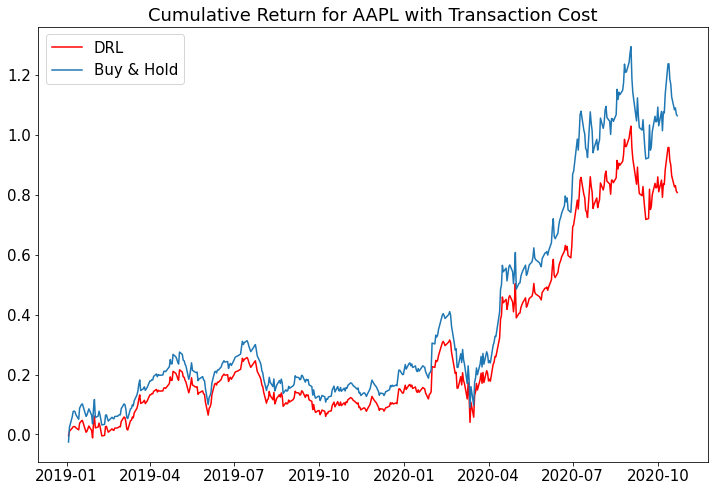

In [62]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(12, 8))

plt.plot(test.datadate, DRL_cumulative_return, color='red',label = "DRL")
plt.plot(test.datadate, buy_and_hold_cumulative_return, label = "Buy & Hold")
plt.title("Cumulative Return for AAPL with Transaction Cost",size= 18)
plt.legend()
plt.rc('legend',fontsize=15)
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)